# Motivation
I'm interested in trying to visualize some features within the letter-detection CNN that I've trained. I'm going to experiment with that in this notebook. 

# Setup
The cells below will setup the rest of the notebook. 

I'll start by configuring my kernel: 

In [1]:
# Changing the cwd to the root of the repo 
%cd ..

# Enabling the autoreload module
%load_ext autoreload
%autoreload 2

d:\data\programming\boggle-vision


Now, I'm going to import any necessary libraries: 

In [2]:
# General import statements
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import traceback
from pathlib import Path
from PIL import Image

# Torch-related import statements
import torch
from torch import nn
from torch.autograd import Function
from torchvision.io import read_image

# Imports custom to this project
from utils.cnn import BoggleCNN
import utils.board_detection as board_detect

Finally, I'll load in the CNN that I've trained.

In [3]:
# Loading in the model
letter_detect_model = BoggleCNN()
letter_detect_model.load_state_dict(torch.load("models/boggle_cnn.pth"))

# Put the model into evaluation mode
letter_detect_model.eval()

BoggleCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=12800, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=32, bias=True)
  )
)

# Loading Data
Next, I need to load in some of the data that I'll be running through the net. 

In [4]:
# Open the .csv file containing the labeled boards
board_data_df = pd.read_csv("data/labeled-boards.csv")

# Add a column which is the parsed letter sequence
board_data_df["parsed_letter_sequence"] = board_data_df["letter_sequence"].apply(
    lambda letter_list: letter_list.split(";")
)

# Load all of the images using cv2
file_path_to_image = {}
for row in tqdm(list(board_data_df.itertuples())):
    file_path_to_image[row.file_path] = cv2.imread(row.file_path)

Next, I'll spend some time actually solving all of the Boggle boards. For each board, I'm going to extract the images that're passed into the Boggle board. 

In [5]:
# We'll collect data about each tile of each board in this dictionary
board_file_path_to_tile_data_dict = {}

# Iterate through all of the rows in the board data
print(f"APPLYING OCR TO BOGGLE BOARDS")
for row in tqdm(list(board_data_df.query("difficulty == 'easy'").itertuples())):
    
    # Parse the board file_path from the row 
    board_file_path = row.file_path
    
    # Try and parse the board
    error_msg = None
    try:
        parsed_board_df, tile_idx_to_image_dict = board_detect.parse_boggle_board(
            file_path_to_image[row.file_path],
            max_image_height=1200,
            model=letter_detect_model,
            return_list=["parsed_board", "tile_images"],
        )
        
        # Create a dictionary mapping the tile_idx to the predicted letter
        tile_idx_to_predicted_letter_dict = {
            row.tile_idx: row.letter for row in parsed_board_df.itertuples()
        }
        
        # Create a dictionary mapping the tile_idx to various data about that tile
        tile_idx_to_data_dict = {
            row.tile_idx: {
                "predicted_letter": tile_idx_to_predicted_letter_dict[row.tile_idx],
                "actual_letter": row.letter,
                "tile_image": tile_idx_to_image_dict[row.tile_idx],
            }
            for row in parsed_board_df.itertuples()
        } 
        
        # Store this board's data in the dictionary
        board_file_path_to_tile_data_dict[board_file_path] = tile_idx_to_data_dict

    except Exception as e:
        print(traceback.format_exc())
        error_msg = str(e)
        letter_sequence = None

100%|██████████| 30/30 [00:43<00:00,  1.46s/it]


# Activation Heatmaps
The first thing I want to try is creating activation heatmaps for different user inputs. During [a conversation with ChatGPT](https://chat.openai.com/share/a33e6386-1fab-43ec-adc3-1e0637681855), I was pointed towards some sample code that uses [PyTorch hooks](https://pytorch.org/docs/stable/generated/torch.Tensor.register_hook.html) to save pixel activation data. 

I'm going to experiment with that code below! I'll start by defining the hook and attaching it to my `letter_detect_model`.

In [21]:
class SaveFeatures(nn.Module):
    """
    This hook will extract the activqaations of a particular layer.
    """

    def __init__(self, module):
        """
        The constructor of the class.
        """
        self.features = None
        self.hook = module.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        """
        This function will be called when the hook is triggered.
        """
        self.features = output.cpu().detach().numpy()

    def close(self):
        """
        This function will close the hook.
        """
        self.hook.remove()

# Attach the hook to the last convolutional layer 
final_conv_layer = letter_detect_model.features[-2]
activated_features = SaveFeatures(final_conv_layer)

Now, with this hook in hand, I can try my hand at visualizing some features. First, I'll load in some test data, and prepare it for the CNN:

In [22]:
# Extract some data from the board_file_path_to_tile_data_dict
# This will be our test data
test_board_file_path, test_tile_data_dict = list(
    board_file_path_to_tile_data_dict.items()
)[0]

# Extract each of the tensors from the test_tile_data_dict
# Create a list of the images and their corresponding indices
test_img_tensor_list = []
for image_idx, tile_data in test_tile_data_dict.items():
    
    # TODO: This is suboptimal as hell. I gotta figure out how to 
    # retrain the model to not introduce compression artifacts from 
    # saving the image as a .png file.
    
    # Extract the image from the tile_data
    image = tile_data.get("tile_image")
    
    # Save the image as a .png file
    Image.fromarray(image).save(f"{image_idx}.png")
    
    # Use read_image() to read in the tensor
    img_tensor = read_image(f"{image_idx}.png").float()
    
    # Delete the image file
    Path(f"{image_idx}.png").unlink()
    
    # Add the image to the list
    test_img_tensor_list.append(img_tensor)

Next, I'm going to iterate through each tensor and try to save the layer activations. 

100%|██████████| 36/36 [00:00<00:00, 77.10it/s]


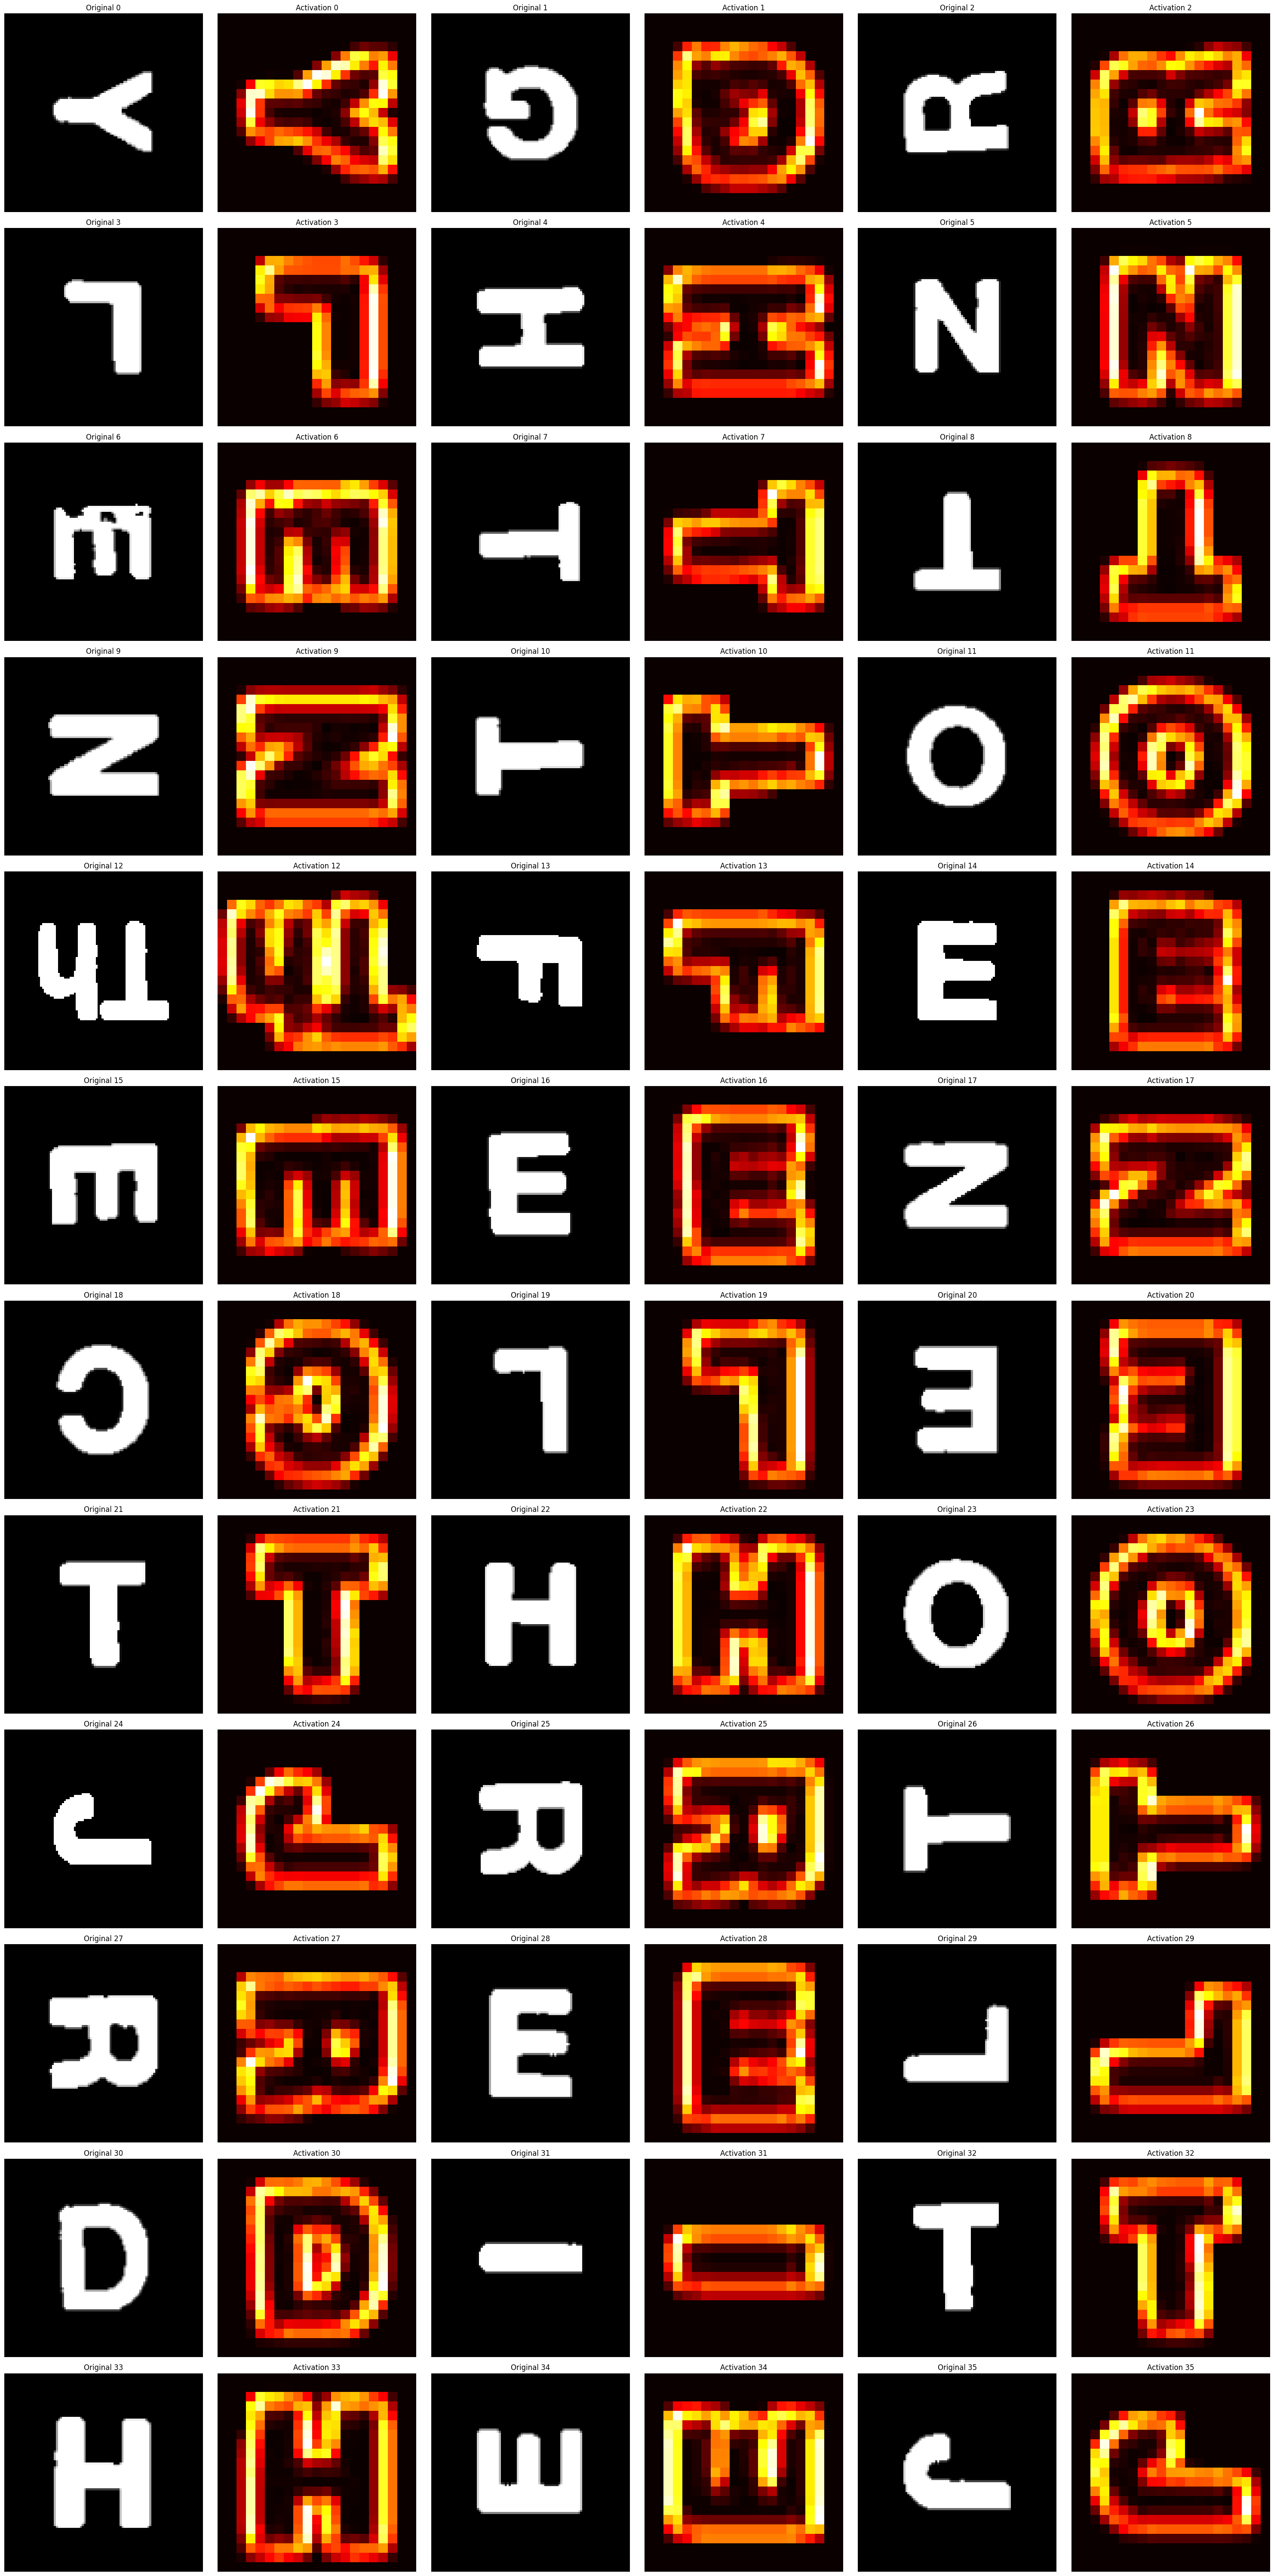

In [23]:
import matplotlib.pyplot as plt

# Each 'tile group' consists of 2 images, the original and the activation, so 6 images per row
cols_per_row = 6
# Calculate the required number of rows, considering each 'tile group' has 2 images (original + activation)
rows = (len(test_img_tensor_list) + 1) // 3  # Add 1 for integer rounding up

# Create a figure with subplots in a grid
fig, axes = plt.subplots(rows, cols_per_row, figsize=(5 * cols_per_row, 5 * rows))

# Ensure axes is a 2D array for easy indexing
if len(test_img_tensor_list) < 3:
    axes = [axes]

# Flatten the axes array if only one row is present
if rows == 1:
    axes = axes.flatten()

for i, img_tensor in tqdm(list(enumerate(test_img_tensor_list))):
    # Run the model on the image
    letter_detect_model(img_tensor.unsqueeze(0))
    
    # Extract the activations from the hook
    activations = activated_features.features
    
    # Convert activations to a tensor if they are not already
    if not isinstance(activations, torch.Tensor):
        activations = torch.tensor(activations)
        
    # Averaging over channels to get a single activation map
    heatmap = activations.squeeze().mean(0).detach().numpy()  # Ensure it's a numpy array for plotting

    # Calculate the row and column index for the original image and activation
    row_idx = (i * 2) // cols_per_row
    col_idx_original = (i * 2) % cols_per_row
    col_idx_activation = col_idx_original + 1
    
    # Plot the original image
    axes[row_idx, col_idx_original].imshow(img_tensor.squeeze().numpy(), cmap='gray')  # Squeeze to remove channel dim if it's 1
    axes[row_idx, col_idx_original].set_title(f'Original {i}')
    axes[row_idx, col_idx_original].axis('off')  # Hide the axis

    # Plot the activation heatmap
    axes[row_idx, col_idx_activation].imshow(heatmap, cmap='hot')
    axes[row_idx, col_idx_activation].set_title(f'Activation {i}')
    axes[row_idx, col_idx_activation].axis('off')  # Hide the axis

# Hide any unused axes if there are any left over
for j in range(i * 2 + 2, rows * cols_per_row):
    axes[j // cols_per_row, j % cols_per_row].axis('off')

plt.tight_layout()
plt.show()
